In [1]:
from nldg.utils import *
from nldg.ss import *

NAME_SS = "WORME-SS"

## WORME Smoothing Splines

In [2]:
dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

dte = gen_data_v6(n=1000, noise_std=0.5, setting=2, new_x=True, random_state=42)
Xte = np.array(dte.drop(columns=['E', 'Y']))
Yte = np.array(dte['Y'])
Ete = np.array(dte['E'])

In [3]:
# instead of cv=True, you can set lam=0.15 (or whatever reasonable value)
erm_ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [4]:
fitted_erm = erm_ss.predict(Xte)
max_mse(Yte, fitted_erm, Ete, verbose=True)

Environment 0 MSE: 24.1933831497903
Environment 1 MSE: 10.53275999714007
Environment 2 MSE: 4.647369300144564


np.float64(24.1933831497903)

In [5]:
worme_ss = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, solver="ECOS")
preds_worme = worme_ss.predict(x_grid)

In [6]:
fitted_worme = worme_ss.predict(Xte)
max_mse(Yte, fitted_worme, Ete, verbose=True)

Environment 0 MSE: 15.603331995158882
Environment 1 MSE: 18.508207226655493
Environment 2 MSE: 10.276211724698443


np.float64(18.508207226655493)

In [7]:
magging_ss = MaggingSmoothSpline()
_ = magging_ss.fit(Xtr, Ytr, Etr)
fitted_magging = magging_ss.predict(Xte)
preds_magging = magging_ss.predict(x_grid)
max_mse(Yte, fitted_magging, Ete, verbose=True)

Environment 0 MSE: 30.666301544424762
Environment 1 MSE: 6.700950139731095
Environment 2 MSE: 2.237266783781151


np.float64(30.666301544424762)

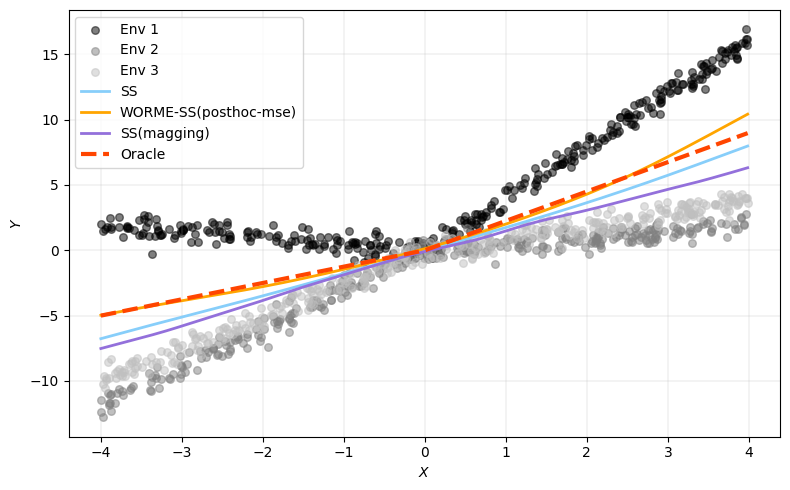

In [8]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_worme, preds_magging=preds_magging,
            optfun=4, saveplot=True, nameplot="setting9_ss")

In [16]:
dtr = gen_data_v7(n=1500, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

dte = gen_data_v7(n=1500, new_x=True, random_state=42)
Xte = np.array(dte.drop(columns=['E', 'Y']))
Yte = np.array(dte['Y'])
Ete = np.array(dte['E'])

In [17]:
erm_ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [18]:
fitted_erm = erm_ss.predict(Xte)
max_mse(Yte, fitted_erm, Ete, verbose=True)

Environment 0 MSE: 0.6050758085985266
Environment 1 MSE: 1.0709013233086653
Environment 2 MSE: 0.2130078339612361


np.float64(1.0709013233086653)

In [19]:
worme_ss = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True)
preds_worme = worme_ss.predict(x_grid)

In [20]:
fitted_worme = worme_ss.predict(Xte)
max_mse(Yte, fitted_worme, Ete, verbose=True)

Environment 0 MSE: 0.731822736921259
Environment 1 MSE: 0.8278425378380411
Environment 2 MSE: 0.4170932447477559


np.float64(0.8278425378380411)

In [21]:
magging_ss = MaggingSmoothSpline()
_ = magging_ss.fit(Xtr, Ytr, Etr)
fitted_magging = magging_ss.predict(Xte)
preds_magging = magging_ss.predict(x_grid)
max_mse(Yte, fitted_magging, Ete, verbose=True)

Environment 0 MSE: 0.32913927542621885
Environment 1 MSE: 1.4237060759725568
Environment 2 MSE: 0.32922304425686194


np.float64(1.4237060759725568)

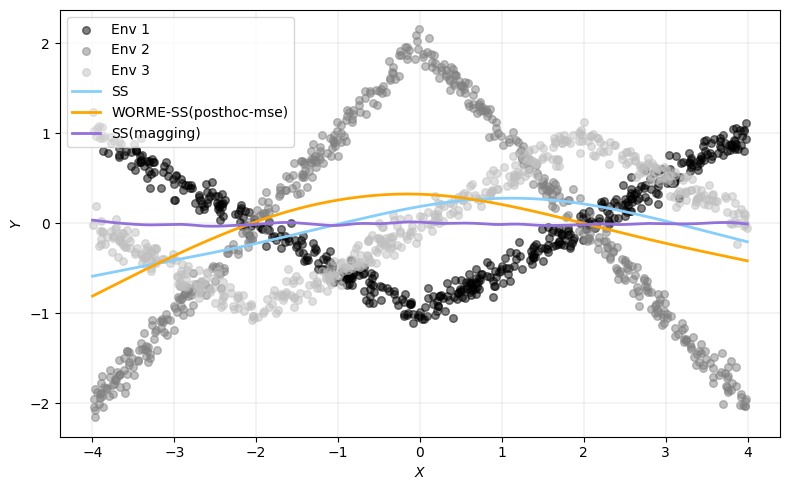

In [15]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_worme, preds_magging=preds_magging,
            saveplot=True, nameplot="setting6_ss")

## Different Objectives

In [31]:
demean_setting = 1
dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

dte = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2, random_state=42)
Xte = np.array(dte.drop(columns=['E', 'Y']))
Yte_orig = np.array(dte['Y'])
Ete = np.array(dte['E'])

if demean_setting == 1:
    Ytr = Ytr_orig
    Yte = Yte_orig
    demean = False
elif demean_setting == 2:
    demean = True
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])
    Yte = np.zeros_like(Yte_orig)
    for env in np.unique(Ete):
        idx = Ete == env
        Yte[idx] = Yte_orig[idx] - np.mean(Yte_orig[idx])

# Fit standard SS for each environment separately.
# This is used for the regret
sols_erm = np.zeros(Etr.shape[0])
sols_erm_te = np.zeros(Ete.shape[0])
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    ss_e = MinMaxSmoothSpline(X_e, Y_e, cv=True, method="erm")
    fitted_e = ss_e.predict(X_e)
    sols_erm[mask] = fitted_e

    mask_e_te = Ete == env
    fitted_e_te = ss_e.predict(Xte[mask_e_te])
    sols_erm_te[mask_e_te] = fitted_e_te

#### Standard SS

In [32]:
ss = MinMaxSmoothSpline(Xtr, Ytr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_ss = ss.predict(x_grid)
fitted_ss = ss.predict(Xte)

mse_ss, _ = max_mse(Yte, fitted_ss, Ete, ret_ind=True)
rw_ss, _ = min_reward(Yte, fitted_ss, Ete, ret_ind=True)
regret_ss, _ = max_regret(Yte, fitted_ss, sols_erm_te, Ete, ret_ind=True)

#### MSE

In [33]:
ss_mse = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="mse")
preds_mse = ss_mse.predict(x_grid)
fitted_mse = ss_mse.predict(Xte)

mse_mse, _ = max_mse(Yte, fitted_mse, Ete, ret_ind=True)
rw_mse, _ = min_reward(Yte, fitted_mse, Ete, ret_ind=True)
regret_mse, _ = max_regret(Yte, fitted_mse, sols_erm_te, Ete, ret_ind=True)

### Reward

In [34]:
ss_rw = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="reward")
preds_rw = ss_rw.predict(x_grid)
fitted_rw = ss_rw.predict(Xte)

mse_rw, _ = max_mse(Yte, fitted_rw, Ete, ret_ind=True)
rw_rw, _ = min_reward(Yte, fitted_rw, Ete, ret_ind=True)
regret_rw, _ = max_regret(Yte, fitted_rw, sols_erm_te, Ete, ret_ind=True)

#### Regret

In [35]:
ss_regret = MinMaxSmoothSpline(Xtr, Ytr, Etr, cv=True,
                               method="regret", sols_erm=sols_erm)
preds_regret = ss_regret.predict(x_grid)
fitted_regret = ss_regret.predict(Xte)

mse_regret, _ = max_mse(Yte, fitted_regret, Ete, ret_ind=True)
rw_regret, _ = min_reward(Yte, fitted_regret, Ete, ret_ind=True)
regret_regret, _ = max_regret(Yte, fitted_regret, sols_erm_te, Ete, ret_ind=True)

#### SS - magging

In [36]:
ss_magging = MaggingSmoothSpline()
_ = ss_magging.fit(Xtr, Ytr, Etr)
fitted_magging = ss_magging.predict(Xte)
preds_magging = ss_magging.predict(x_grid)

mse_magging, _ = max_mse(Yte, fitted_magging, Ete, ret_ind=True)
rw_magging, _ = min_reward(Yte, fitted_magging, Ete, ret_ind=True)
regret_magging, _ = max_regret(Yte, fitted_magging, sols_erm_te, Ete, ret_ind=True)

#### Comparison

In [37]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Reward", "Regret"], ["0", "1"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_ss + rw_ss + regret_ss],
    [round(float(x), 3) for x in mse_mse + rw_mse + regret_mse],
    [round(float(x), 3) for x in mse_rw + rw_rw + regret_rw],
    [round(float(x), 3) for x in mse_regret + rw_regret + regret_regret],
    [round(float(x), 3) for x in mse_magging + rw_magging + regret_magging],
]
df = pd.DataFrame(
    data,
    index=
    [
        "SS",
        f"{NAME_SS}(posthoc-mse)",
        f"{NAME_SS}(posthoc-nrw)",
        f"{NAME_SS}(posthoc-reg)",
        "SS(magging)"
    ],
    columns=cols)
print(df)

Metric                   MSE         Reward         Regret        
Env                        0       1      0       1      0       1
SS                     0.426  15.182  1.109  12.597  0.171  12.107
WORME-SS(posthoc-mse)  6.576   4.952 -5.041  22.826  6.320   1.878
WORME-SS(posthoc-nrw)  0.255  18.116  1.280   9.662 -0.001  15.042
WORME-SS(posthoc-reg)  4.349   6.556 -2.814  21.223  4.093   3.481
SS(magging)            0.256  18.113  1.279   9.665  0.000  15.039


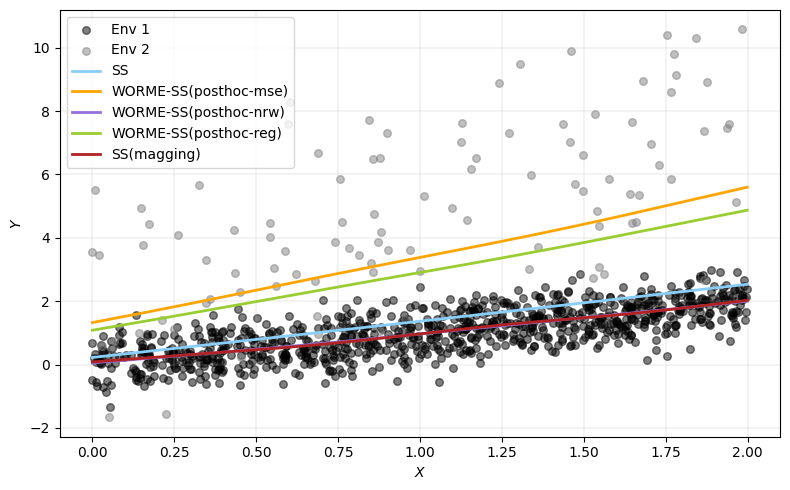

In [38]:
plot_dtr_ss(dtr, x_grid, preds_ss, preds_mse,
            preds_nrw=preds_rw, preds_regret=preds_regret,
            preds_magging=preds_magging, obj_comparison=True,
            saveplot=True, nameplot="setting8_objectives_ss")